In [23]:
from PIL import Image

In [24]:
init_img = Image.open("/home/pawel/git/NeuralNetworksSketchbook/src/depth_interior.png").convert("RGB")

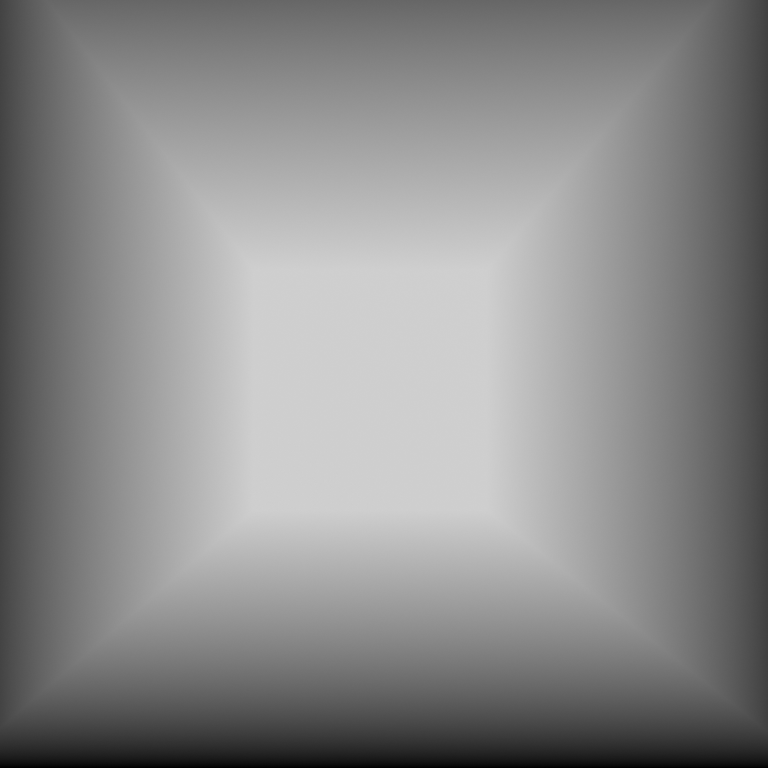

In [25]:
import numpy as np
init_img

In [26]:
import torch
import requests
from diffusers import StableDiffusionDepth2ImgPipeline

pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
   "stabilityai/stable-diffusion-2-depth",
   torch_dtype=torch.float16,
).to("cuda")


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

In [77]:
depth = init_img.copy()
depth.thumbnail((384, 384),Image.ANTIALIAS)
depth = depth.convert('1')
depth = torch.Tensor(np.array(depth)).unsqueeze(0)
#depth *= 100
#depth += 100
depth.shape, depth.min(), depth.max()

/tmp/ipykernel_4687/2478955409.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  depth.thumbnail((384, 384),Image.ANTIALIAS)


(torch.Size([1, 384, 384]), tensor(0.), tensor(1.))

  0%|          | 0/50 [00:00<?, ?it/s]

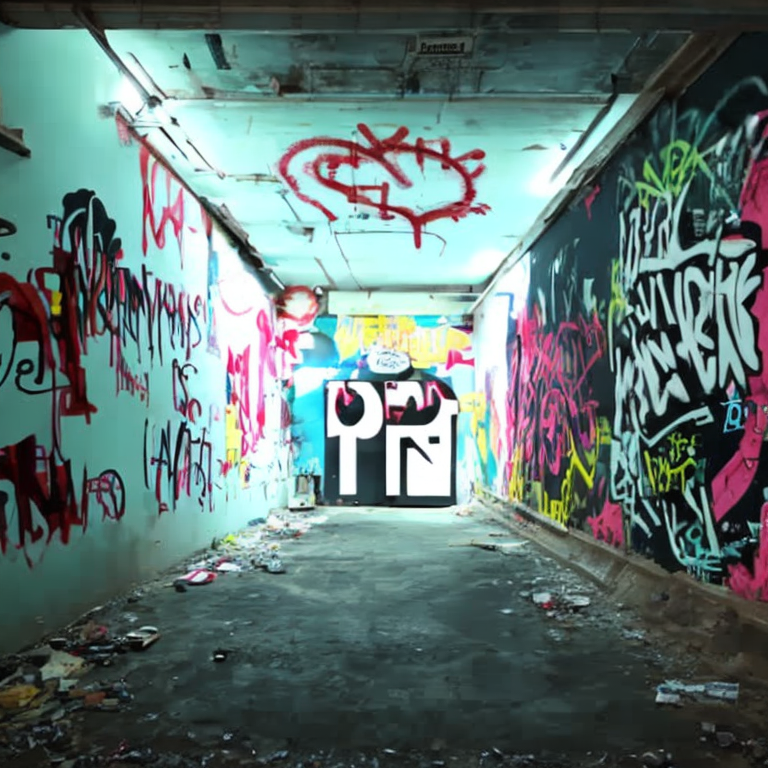

In [140]:
i = 2036
generator = torch.Generator(device="cuda").manual_seed(i)
prompt = "A professional photography of an empty dirty dark workshop, posters and graffiti on the walls, empty ceiling, light from behind the camera, professional, highly detailed, UHD 4k, trending on artstation, sharp, soft light"
n_propmt = "fog, big windows, blurred, car, things on a  ceiling, sharp shadows, strong light"
imgs = pipe(prompt=prompt, image=init_img, depth_map=depth, negative_prompt=n_propmt, guidance_scale=9, strength=1.0, generator=generator, 
            num_inference_steps=50).images
imgs[0]

In [143]:
import numpy as np


model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

import numpy as np


model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

def get_depth(image):
    input_batch = transform(image).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    return prediction.cpu().numpy()
depth = get_depth(np.asarray(imgs[0]))
depth.min(), depth.max()

Using cache found in /home/pawel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/pawel/.cache/torch/hub/intel-isl_MiDaS_master


(1.1946732, 35.49449)

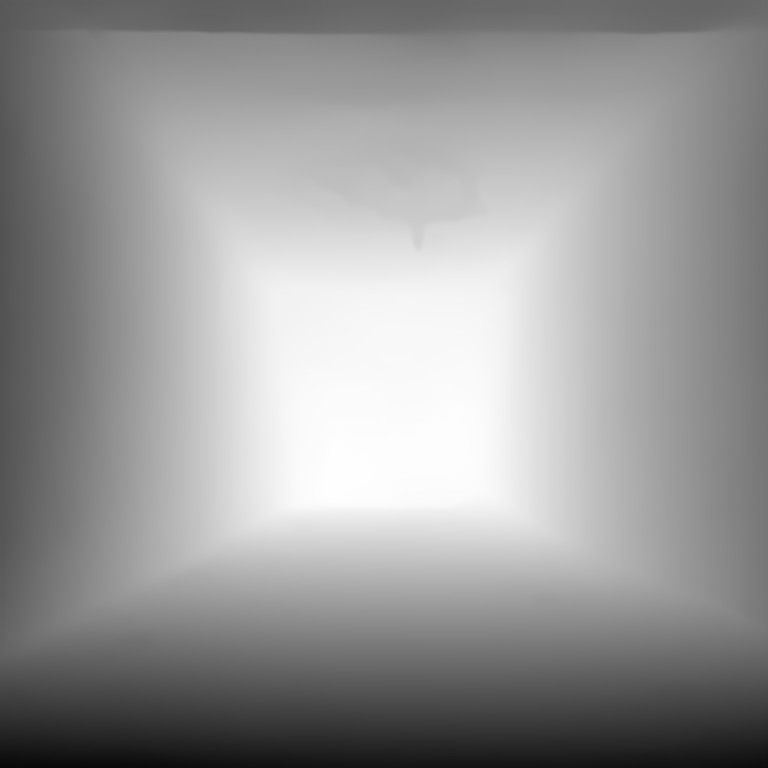

In [149]:
pil_depth = Image.fromarray(np.uint8(255*(1 - (depth - depth.min())/depth.max()))).convert('RGB')
pil_depth

In [171]:
init_img_array = np.float32(np.array(init_img))
init_img_array /= init_img_array.max()

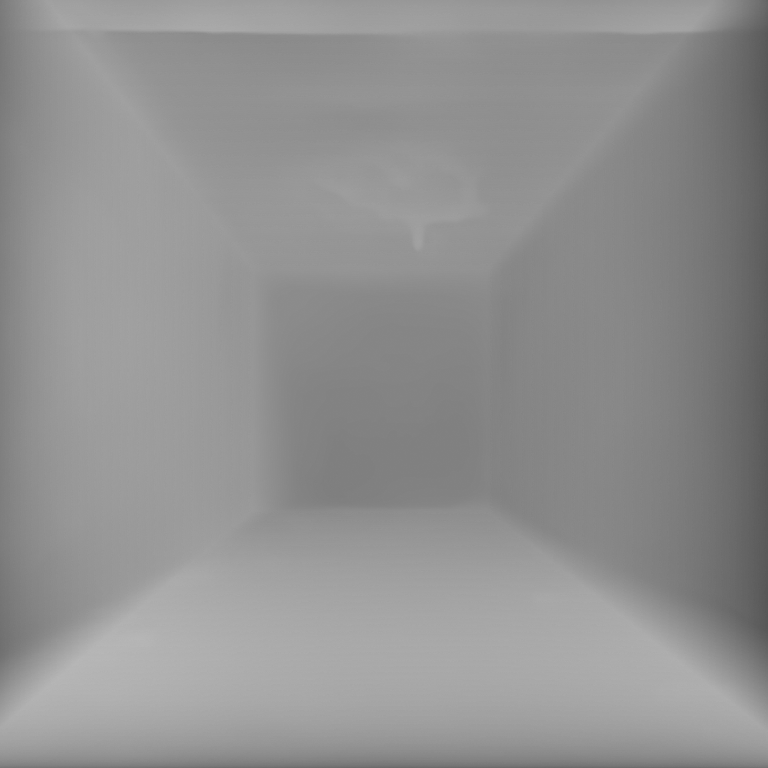

In [172]:
Image.fromarray(np.uint8((((init_img_array) - np.array(pil_depth) / 255) + 0.5) * 255))

In [207]:
import pyvista as pv
mesh = pv.read("src/house2.obj")

tex = pv.numpy_to_texture(np.array(imgs[0]))

pl = pyvista.Plotter()
pl.add_mesh(mesh, texture=tex, lighting=False)
pl.camera.position = (-0.357514, 23.7071,  1.23872)
pl.camera.rotation = (-0.023186, 91.6206,  88.9698)
view_angle = 50
pl.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [1]:
from diffusers import (
    StableDiffusionPipeline
    )       
import torch


device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
     

# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
     
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)


2023-01-16 21:21:55.503571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 21:21:56.132303: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda-11.4/extras/Debugger/lib64:/usr/local/cuda-11.4/extras/Debugger/include
2023-01-16 21:21:56.132356: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/home/pawel/projekty/aiart/venv/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


2023-01-16 20:27:53.687262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 20:27:54.260288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda-11.4/extras/Debugger/lib64:/usr/local/cuda-11.4/extras/Debugger/include
2023-01-16 20:27:54.260341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/home/pawel/projekty/aiart/venv/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/35 [00:00<?, ?it/s]

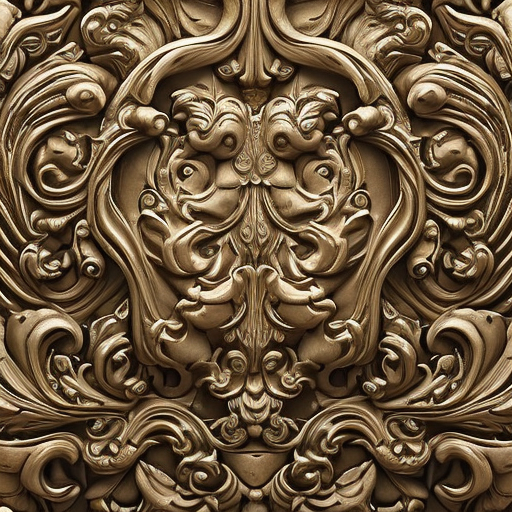

In [1]:

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="An artistic baroque emboss, professional, highly detailed, UHD 4k, trending on artstation", # What to generate
    negative_prompt="",
    guidance_scale=8,        
    num_inference_steps=35,
    generator=generator   
)

# View the resulting image:
pipe_output.images[0]

In [20]:
import numpy as np
from PIL import Image

model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

import numpy as np


model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

def get_depth(image):
    input_batch = transform(image).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    return prediction.cpu().numpy()

Using cache found in /home/pawel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/pawel/.cache/torch/hub/intel-isl_MiDaS_master


Using cache found in /home/pawel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/pawel/.cache/torch/hub/intel-isl_MiDaS_master


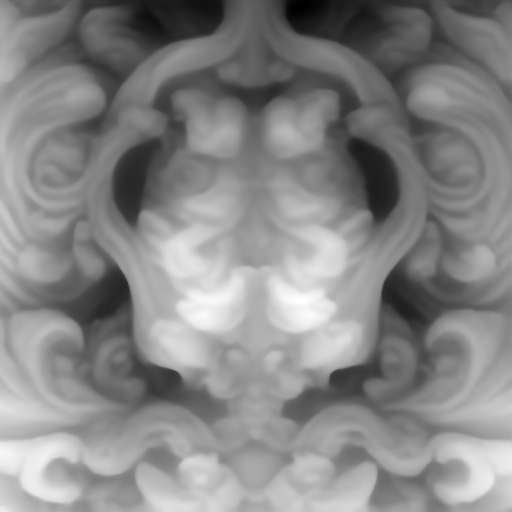

In [2]:

depth = get_depth(np.asarray(pipe_output.images[0]))
depth -= depth.min()
depth /= depth.max()
depth *= 255
depth_img = Image.fromarray(np.uint8(depth))
depth_img

In [4]:
depth.min(), depth.max()

(16.971832, 23.781319)

  0%|          | 0/35 [00:00<?, ?it/s]

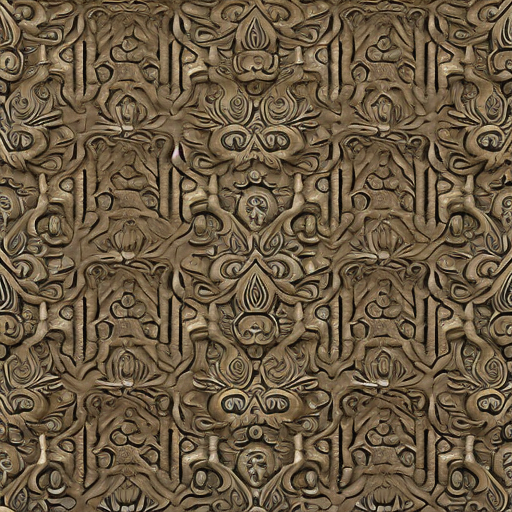

In [2]:
# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="A seamless, tileable cell of baroque emboss, professional, highly detailed, UHD 4k, trending on artstation", # What to generate
    negative_prompt="",
    guidance_scale=8,        
    num_inference_steps=35,
    generator=generator   
)

# View the resulting image:
pipe_output.images[0]

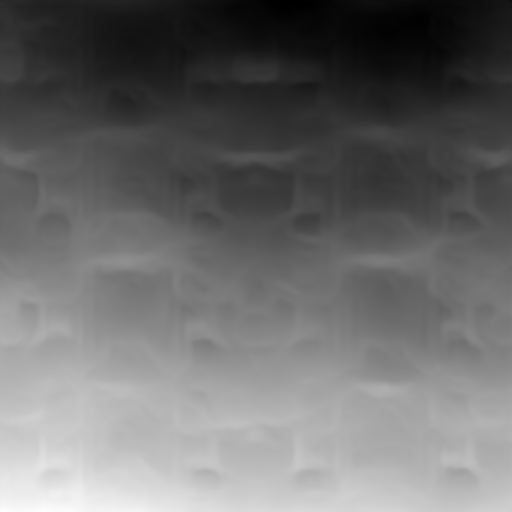

In [5]:

depth = get_depth(np.asarray(pipe_output.images[0]))
depth -= depth.min()
depth /= depth.max()
depth *= 255
depth_img = Image.fromarray(np.uint8(depth))
depth_img

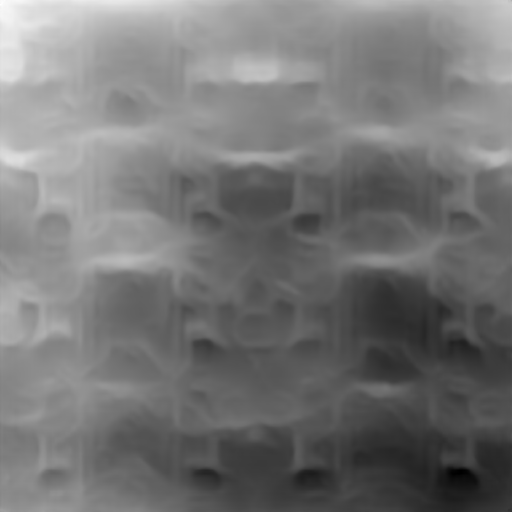

In [27]:
def get_gradient_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T
grad = get_gradient_2d(255, 0, 512, 512, False)
correction = depth + grad
correction -= correction.min()
correction /= correction.max()
correction *= 255
Image.fromarray(np.uint8(correction))

In [49]:
import pyvista as pv

depth = np.array(Image.open("/home/pawel/git/NeuralNetworksSketchbook/out/emboss_z.png").convert("RGB"))
array = np.asarray(depth)
resolution = array.shape[0]
size = resolution*resolution
# Define a simple Gaussian surface
n = resolution
x = np.linspace(-200, 200, num=n)
y = np.linspace(-200, 200, num=n)
xx, yy = np.meshgrid(x, y)

fc_x, fc_y, fc_z = [resolution/2, resolution/2, -10]
for row in range(resolution):
    for column in range(resolution):
        z[row][column] = depth[resolution-row - 1][resolution-column - 1][0]

# Get the points as a 2D NumPy array (N by 3)
points = np.c_[xx.reshape(-1), yy.reshape(-1), z.reshape(-1)]
curvsurf = pv.StructuredGrid(xx, yy, z / 4)
curvsurf.texture_map_to_plane(inplace=True)

StructuredGrid (0x7f23aec5dee0)
  N Cells:	261121
  N Points:	262144
  X Bounds:	-2.000e+02, 2.000e+02
  Y Bounds:	-2.000e+02, 2.000e+02
  Z Bounds:	0.000e+00, 6.375e+01
  Dimensions:	512, 512, 1
  N Arrays:	1

In [50]:
depth.shape

(512, 512, 3)

In [51]:

tex = pv.numpy_to_texture(np.array(Image.open("/home/pawel/git/NeuralNetworksSketchbook/out/emboss_c.png").convert("RGB")))
curvsurf.plot(texture = tex)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [97]:

depth = np.array(Image.open("/home/pawel/git/NeuralNetworksSketchbook/out/emboss2_z.png").convert("RGB"))
array = np.asarray(depth)
resolution = array.shape[0]
size = resolution*resolution
# Define a simple Gaussian surface
n = resolution
x = np.linspace(-200, 200, num=n)
y = np.linspace(-200, 200, num=n)
xx, yy = np.meshgrid(x, y)

fc_x, fc_y, fc_z = [resolution/2, resolution/2, -10]
for row in range(resolution):
    for column in range(resolution):
        z[row][column] = depth[resolution-row - 1][resolution-column - 1][0]

# Get the points as a 2D NumPy array (N by 3)
points = np.c_[xx.reshape(-1), yy.reshape(-1), z.reshape(-1)]
curvsurf = pv.StructuredGrid(xx, yy, z / 4)
curvsurf.texture_map_to_plane(inplace=True)

tex = pv.numpy_to_texture(np.array(Image.open("/home/pawel/git/NeuralNetworksSketchbook/out/emboss2_c.png").convert("RGB")))

r = (7.5, 1, 0)

pl = pv.Plotter()
t0 = pl.add_mesh(curvsurf, texture=tex, lighting=False)
t0.position = (0, 403.5, 0)
t0.orientation = r
t1 = pl.add_mesh(curvsurf, texture=tex, lighting=False)
t1.position = (0, 0, 0)
t1.orientation = r
t2 = pl.add_mesh(curvsurf, texture=tex, lighting=False)
t2.position = (0, 403.5*2, 0)
t2.orientation = r


t0 = pl.add_mesh(curvsurf, texture=tex, lighting=False)
t0.position = (400, 403.5, 0)
t0.orientation = r
t1 = pl.add_mesh(curvsurf, texture=tex, lighting=False)
t1.position = (400, 0, 0)
t1.orientation = r
t1 = pl.add_mesh(curvsurf, texture=tex, lighting=False)
t1.orientation = r
t2 = pl.add_mesh(curvsurf, texture=tex, lighting=False)
t2.position = (400, 403.5*2, 0)
t2.orientation = r

pl.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/60 [00:00<?, ?it/s]

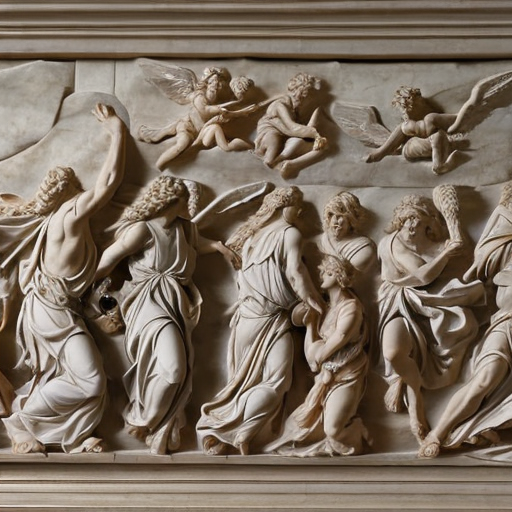

In [19]:
# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Baroque bas-relief of a dynamic biblical scene, multiple figures, from distance, marble, anatomically correct, professional, highly detailed, UHD 4k, trending on artstation by Erastus Dow Palmer ",
    negative_prompt="deformed faces",
    guidance_scale=8,        
    num_inference_steps=60,
    generator=generator   
)

# View the resulting image:
pipe_output.images[0]

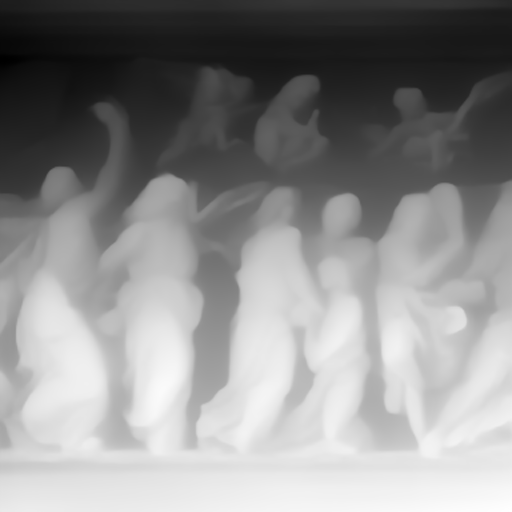

In [22]:

depth = get_depth(np.asarray(pipe_output.images[0]))
depth -= depth.min()
depth /= depth.max()
depth *= 255
depth_img = Image.fromarray(np.uint8(depth))
depth_img

In [26]:
import pyvista as pv

z = np.ones((512, 512))
depth = np.array(Image.open("/home/pawel/git/NeuralNetworksSketchbook/out/emboss3_z.png").convert("RGB"))
array = np.asarray(depth)
resolution = array.shape[0]
size = resolution*resolution
# Define a simple Gaussian surface
n = resolution
x = np.linspace(-200, 200, num=n)
y = np.linspace(-200, 200, num=n)
xx, yy = np.meshgrid(x, y)

fc_x, fc_y, fc_z = [resolution/2, resolution/2, -10]
for row in range(resolution):
    for column in range(resolution):
        z[row][column] = depth[resolution-row - 1][column][0]

# Get the points as a 2D NumPy array (N by 3)
points = np.c_[xx.reshape(-1), yy.reshape(-1), z.reshape(-1)]
curvsurf = pv.StructuredGrid(xx, yy, z / 4)
curvsurf.texture_map_to_plane(inplace=True)


tex = pv.numpy_to_texture(np.array(Image.open("/home/pawel/git/NeuralNetworksSketchbook/out/emboss3_c.png").convert("RGB")))
curvsurf.plot(texture = tex)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)